# Outline

Predicting quantitative mRNA abundance in E. coli K-12 MG1655 with convolutional neural network based on one-hot promoter/gene sequence

# Import Packages

In [68]:
# built-in
from pathlib import Path
import sys

# third-party (install required)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from tensorflow import keras

# sub-import from keras
from tensorflow.keras import backend as K

# local modules
sys.path.append('../../bitome2')

from bitome.core import Bitome

# define paths
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# Construct K-12 MG1655 Bitome

In [2]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [3]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Construct Gene Dataset

Start from genes; we want those that have expression data and known single TSSes, for now

In [16]:
def single_tss_for_gene(gene_row):
    
    # get the TUs for the gene; for starters, only deal with those that have TSS
    gene_tus = mg1655._gene_to_tus[gene_row.name]
    gene_tu_df = mg1655.tu_table.loc[gene_tus]
    gene_tu_df = gene_tu_df[gene_tu_df['tss'].notna()]

    # get the unique TSS for the gene; skip multi-TSS genes for the moment
    gene_tsses = gene_tu_df['tss'].unique()
    
    # return the TSS if just 1; otherwise None
    if len(gene_tsses) == 1:
        return gene_tsses[0]
    else:
        return None

# modify the gene table to include single TSS information, if applicable
gene_table_tss = mg1655.gene_table.copy()
gene_table_tss['tss'] = gene_table_tss.apply(single_tss_for_gene, axis=1)
gene_table_tss = gene_table_tss.dropna(subset=['tss', 'log_tpm'])

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm,tss
locus_tag,,,,,,,,,,,,,,
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268,148.0
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776,148.0
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337,148.0
b0008,8238,9191,1,False,talB,G,NaN,well-annotated,1205.756621,1643.706773,1379.751727,NaN,10.236919,8191.0
b0025,21407,22348,1,False,ribF,H,True,well-annotated,255.328032,287.540154,245.700279,NaN,8.001847,21383.0


# Construct ML Dataset

In [26]:
def create_tss_sequence_dataset(bitome_obj, tss_df, n_upstream=200, n_downstream=200):

    sequence_length = n_upstream + n_downstream + 1

    # save some code and cut off TSS that are too close to sequence edges
    tss_df = tss_df[
        (tss_df['tss'] > max(n_upstream, n_downstream)) &
        (len(bitome_obj.sequence) - tss_df['tss'] > max(n_upstream, n_downstream))
    ]

    tss_sequence_rows = []

    def get_tss_sequence(tss, strand, n_upstream, n_downstream):
        # use the strand to define the correct sequence range 
        if strand == 1:
            left, right = tss - n_upstream, tss + n_downstream
        else:
            left, right = tss - n_downstream, tss + n_upstream
        tss_sequence = str(bitome_obj.get_sequence(left, right, strand))
        return tss_sequence

    for tss_id, tss_row in tss_df.iterrows():

        # extract strand information; use to extract desired sequence
        true_tss, strand = tss_row['tss'], tss_row['strand']
        tss_sequence = get_tss_sequence(true_tss, strand, n_upstream, n_downstream)

        # add a row to our running DataFrame row list
        tss_sequence_rows.append({
            'tss_id': tss_id,
            'tss': true_tss,
            'strand': strand,
            'sequence': tss_sequence,
            'label': tss_row['log_tpm']
        })

    # create a DataFrame from the individual rows we've prepared
    tss_sequence_df = pd.DataFrame(tss_sequence_rows)

    # initialize a Numpy array to store the one-hot encoded sequences
    # should have shape: (n_examples, 4 (for bases), sequence_length)
    tss_data_array = np.empty((tss_sequence_df.shape[0], sequence_length, 4))

    # for each sequence in the sequence DF, prepare the one-hot version
    def one_hot_encode_sequence(seq):
        base_to_ind = dict(zip('ACGT', range(4)))    
        seq_mapped = [base_to_ind[base] for base in seq]
        return np.eye(4)[seq_mapped]

    for i, sequence in enumerate(tss_sequence_df['sequence']):
        tss_data_array[i] = one_hot_encode_sequence(sequence)
        
    return tss_sequence_df, tss_data_array

# Create Model

Develop a CNN architecture; leave various hyperparameters so we can try varying the architecture later

We want 1-D convolutions because we're dealing with sequence

We definitely want "valid" padding because we want to reduce dimensionality at each convolutional layer

In [75]:
def build_cnn(conv_layer_df, dense_layer_df, sequence_length):
    
    # initiate a sequential Keras model to which we can add our layers
    model = keras.Sequential()
    
    # add an input layer to specify the input shape;
    # input shape is (timesteps (i.e. sequence length), dimension of each timestep (i.e. 4 always, 1-hot encoded))
    model.add(keras.layers.InputLayer(input_shape=(sequence_length, 4)))
    
    # add our conv/max pool layers with the specified parameters
    for _, conv_layer_row in conv_layer_df.iterrows():
        
        model.add(keras.layers.Conv1D(
            conv_layer_row['n_filters'],
            (conv_layer_row['filter_size'],),
            strides=(conv_layer_row['stride'],),
            padding='valid',
            activation='relu'
        ))

        model.add(keras.layers.MaxPool1D(
            pool_size=(conv_layer_row['pool_size'],),
            strides=(conv_layer_row['pool_stride'],)
        ))
        
    # after the convolutional layers, we need to flatten and concatenate in order to
    # then feed into fully-connected dense layers
    model.add(keras.layers.Flatten())
    
    # then add fully-connected dense layers as specified
    for _, dense_layer_row in dense_layer_df.iterrows():
        
        model.add(keras.layers.Dense(
            dense_layer_row['n_neurons'],
            activation='relu'
        ))

        if not pd.isna(dense_layer_row['dropout_rate']):
            model.add(keras.layers.Dropout(
                dense_layer_row['dropout_rate']
            ))
            
    # finally, we can always add a single output layer for regression; no activation 
    # since we want all reals to be possible
    model.add(keras.layers.Dense(
        1,
        activation=None
    ))
    
    # compile the model by defining the loss function and optimizer; need to add custom CoD
    def r2(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred))
        SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
        return (1 - SS_res/(SS_tot + K.epsilon()))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[
            keras.metrics.MeanAbsoluteError(name='mae'),
            keras.metrics.MeanAbsolutePercentageError(name='mape'),
            keras.metrics.MeanSquaredError(name='mse'),
            r2
        ]
    )
    
    return model

# Run Trial

In [105]:
def run_trial(
    tss_df,
    # params for creating the dataset
    n_upstream=200, n_downstream=200,
    # params for the convolutional layers
    n_filters=32, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    # params for the dense layers
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    # params for model.fit
    batch_size=32, epochs=50, patience=5
):
    
    # call the function that will create the actual dataset
    tss_sequence_metadata_df, tss_data_array = create_tss_sequence_dataset(
        mg1655, tss_df,
        n_upstream=n_upstream, n_downstream=n_downstream
    )
    
    # now we are ready to define our Xy matrices
    X = tss_data_array
    y = tss_sequence_metadata_df['label']
    
    # set up the cross-validated evaluation of this set of hyperparameters
    result_rows = []

    # use a 5-fold split to create train/val indices
    kf = KFold(n_splits=5, shuffle=True)
    for i_fold, (train_index, val_index) in enumerate(kf.split(X, y)):

        # don't standardize the input data since it's one-hot encoded purely
        X_train = X[train_index, :]
        X_val = X[val_index, :]
        y_train = y[train_index]
        y_val = y[val_index]
        # also create a shuffled training label set and try that too
        y_train_shuffled = y_train.values.copy()
        np.random.shuffle(y_train_shuffled)
        y_to_try = {
            'true': y_train,
            'shuffled': y_train_shuffled
        }

        for y_train_name, y_train_to_use in y_to_try.items():

            # build a fresh model according to this set of hyperparameters
            if isinstance(n_filters, tuple):
                conv_index = None
            else:
                conv_index = [0]
            conv_layer_df = pd.DataFrame(data={
                'n_filters': n_filters, 'filter_size': filter_size, 'stride': stride,
                'pool_size': pool_size, 'pool_stride': pool_stride
            }, index=conv_index)
            if isinstance(n_neurons, tuple):
                dense_index = None
            else:
                dense_index = [0]
            dense_layer_df = pd.DataFrame(data={
                'n_neurons': n_neurons, 'dropout_rate': dropout_rate
            }, index=dense_index)
            cnn_model = build_cnn(conv_layer_df, dense_layer_df, X.shape[1])

            # fit the model; use early stopping to prevent overfitting
            model_history = cnn_model.fit(
                X_train, y_train_to_use,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_r2', mode='max', patience=patience, restore_best_weights=True)],
                validation_data=(X_val, y_val)
            )

            # create an information row to add to our DataFrame;
            best_r2_epoch = np.argmax(model_history.history['val_r2'])
            result_row = {
                'fold': i_fold,
                'y_train': y_train_name,
                'train_r2': model_history.history['r2'][best_r2_epoch],
                'val_r2': model_history.history['val_r2'][best_r2_epoch],
                'train_mae': model_history.history['mae'][best_r2_epoch],
                'val_mae': model_history.history['val_mae'][best_r2_epoch],
                'train_mse': model_history.history['mse'][best_r2_epoch],
                'val_mse': model_history.history['val_mse'][best_r2_epoch],
                'train_mape': model_history.history['mape'][best_r2_epoch],
                'val_mape': model_history.history['val_mape'][best_r2_epoch]
            }
            result_rows.append(result_row)
            
    # finalize and return the result DataFrame
    result_df = pd.DataFrame(result_rows)
    return result_df

# Model Sandbox

Let's try a 5-fold cross validation approach to get an initial sense of how we're doing

In [107]:
trial_result_df = run_trial(
    gene_table_tss,
    n_upstream=250, n_downstream=100,
    n_filters=(32,16), filter_size=(6, 6), stride=(1, 1),
    pool_size=(6, 12), pool_stride=(6, 12),
    n_neurons=(64, 8), dropout_rate=(0.1, 0.05),
    batch_size=32, epochs=200, patience=20
)

Epoch 1/200
42/42 [==============================] - 0s 9ms/step - loss: 31.3968 - mae: 4.9774 - mape: 90.2058 - mse: 31.3968 - r2: -4.4768 - val_loss: 12.2734 - val_mae: 2.8527 - val_mape: 70.1007 - val_mse: 12.2734 - val_r2: -0.6961
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 8.8659 - mae: 2.3869 - mape: 77.2857 - mse: 8.8659 - r2: -0.6328 - val_loss: 8.1691 - val_mae: 2.3432 - val_mape: 91.4993 - val_mse: 8.1691 - val_r2: -0.0791
Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 8.2343 - mae: 2.2606 - mape: 73.2167 - mse: 8.2343 - r2: -0.3661 - val_loss: 8.1050 - val_mae: 2.3338 - val_mape: 90.1865 - val_mse: 8.1050 - val_r2: -0.0682
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 7.9175 - mae: 2.2330 - mape: 71.9763 - mse: 7.9175 - r2: -0.3282 - val_loss: 8.1265 - val_mae: 2.3390 - val_mape: 87.1049 - val_mse: 8.1265 - val_r2: -0.0640
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss:

In [108]:
trial_result_df

,fold,y_train,train_r2,val_r2,train_mae,val_mae,train_mse,val_mse,train_mape,val_mape
0,0,true,0.371448,0.329001,1.334147,1.520908,3.567953,3.991878,34.514084,51.164505
1,0,shuffled,-0.226913,-0.066358,2.140931,2.331218,7.012519,8.079903,72.168785,91.494240
2,1,true,0.567174,0.284545,1.289378,1.475004,2.670995,3.653465,37.272552,39.018990
3,1,shuffled,-0.071169,-0.126915,2.117824,2.004488,6.725803,6.210137,77.970840,58.560940
4,2,true,0.655546,0.157425,1.106836,1.614658,2.081371,4.817551,29.687469,39.141048
5,2,shuffled,-0.195664,-0.078432,2.196750,2.075844,7.558285,6.406547,76.296059,72.976608
6,3,true,0.396872,0.169791,1.544775,1.613687,3.813896,4.045046,46.641205,51.160488
7,3,shuffled,-0.118773,-0.181293,2.199329,2.029616,7.383060,6.071369,74.370399,70.171471
8,4,true,0.745822,0.366585,0.943983,1.381790,1.485364,3.444650,24.931814,40.253685
9,4,shuffled,-1.304763,-0.043654,3.040464,2.015591,13.889170,6.127044,81.277138,68.963074


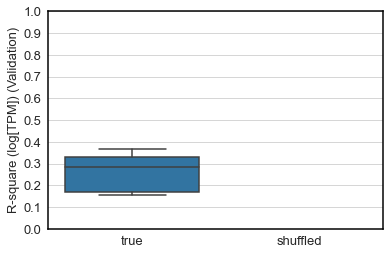

In [109]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.boxplot(x='y_train', y='val_r2', data=trial_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel('R-square (log[TPM]) (Validation)', fontsize=13)
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')